In [275]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import deque


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [276]:
import numpy as np

class TicTacToe:
    def __init__(self):
        """Инициализация среды."""
        self.board_size = 9  
        self.reset()

    def reset(self):
        """Сброс игры."""
        self.board = np.zeros(self.board_size, dtype=np.int8)  
        self.current_player = 1  
        self.done = False
        return self._get_observation()

    def step(self, action):
        """Совершить действие."""
        if self.done:
            raise ValueError("Игра завершена. Вызовите reset().")
        
        # Проверяем допустимость действия
        if self.board[action] != 0:
            reward = -10  # Штраф за недопустимый ход
            self.done = True
            return self._get_observation(), reward, self.done
        
        # Совершаем ход
        self.board[action] = self.current_player

        # Проверяем завершение игры
        if self._check_win(self.current_player):
            reward = 1  # Победа текущего игрока
            self.done = True
        elif np.all(self.board != 0):  # Ничья
            reward = 0.5
            self.done = True
        else:
            reward = -0.01  # Промежуточное состояние
            self.current_player *= -1  # Смена игрока

        return self._get_observation(), reward, self.done

    def _get_observation(self):
        """Возвращает текущее состояние с учетом инверсии для текущего игрока."""
        return self.board * self.current_player

    def _check_win(self, player):
        """Проверка выигрыша."""
        win_indices = [
            [0, 1, 2],  # Первая строка
            [3, 4, 5],  # Вторая строка
            [6, 7, 8],  # Третья строка
            [0, 3, 6],  # Первый столбец
            [1, 4, 7],  # Второй столбец
            [2, 5, 8],  # Третий столбец
            [0, 4, 8],  # Главная диагональ
            [2, 4, 6],  # Побочная диагональ
        ]
        return any(all(self.board[i] == player for i in combo) for combo in win_indices)

In [277]:
class TicTacToeModel(nn.Module):
    def __init__(self):
        super(TicTacToeModel, self).__init__()
        self.fc1 = nn.Linear(9, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 9)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  
        return x

In [278]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import deque

class DeepQAgent:
    def __init__(self, model, action_size, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.model = model
        self.model.to(device)
        self.target_model = TicTacToeModel().to(device)  # Модель-цель
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.memory = deque(maxlen=2000)  # Репозиторий опыта

    def remember(self, state, action, reward, next_state, done):
        """Сохранение опыта в памяти."""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Выбор действия с использованием epsilon-greedy стратегии."""
        if np.random.rand() <= self.epsilon:
            return random.randint(0, self.action_size - 1)  # Случайное действие
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = self.model(state).detach().cpu().numpy()
        return np.argmax(q_values)

    def replay(self, batch_size):
        """Обучение на случайной выборке из памяти."""
        if len(self.memory) < batch_size:
            return

        # Выбор случайного батча
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in batch:
            state = torch.tensor(state, dtype=torch.float32).to(device)
            next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
            target = self.model(state).detach().clone()
            if done:
                target[action] = reward
            else:
                # Q-learning: обновляем только выбранное действие
                next_q_values = self.target_model(next_state).detach()
                target[action] = reward + self.gamma * torch.max(next_q_values)

            # Обновление сети
            self.optimizer.zero_grad()
            output = self.model(state)
            loss = F.mse_loss(output, target)
            loss.backward()
            self.optimizer.step()

        # Постепенное уменьшение epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        """Копирование весов основной сети в модель-цель."""
        self.target_model.load_state_dict(self.model.state_dict())


In [279]:
eps = [1, 100, 500, 1000, 5000, 10000, 50000, 100000]

for episodes in eps:
    print(f"Started for {episodes}")
    env = TicTacToe()
    model = TicTacToeModel()
    agent = DeepQAgent(model, action_size=9)


    #episodes = 5000
    batch_size = 32
    target_update_interval = 10  


    for episode in range(episodes):

        state = env.reset()
        total_reward = 0

        while True:
            # Действие агента
            action = agent.act(state)

            # Среда возвращает следующее состояние
            next_state, reward, done = env.step(action)

            # Сохранение опыта
            agent.remember(state, action, reward, next_state, done)

            # Переход к следующему состоянию
            state = next_state
            total_reward += reward

            # Завершаем эпизод, если игра окончена
            if done:
                break

        # Обучение агента на накопленном опыте
        agent.replay(batch_size)

        # Обновление модели-цели
        if episode % target_update_interval == 0:
            agent.update_target_model()

        # Логируем прогресс
        #print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}")
        
    torch.save(model, f"models\\model_{episodes}.pth")


Started for 1
Started for 100
Started for 500
Started for 1000
Started for 5000
Started for 10000
Started for 50000
Started for 100000


In [308]:
import numpy as np
import torch

class RandomPlayer:
    """Игрок, выбирающий случайные допустимые ходы."""
    def __init__(self, action_size):
        self.action_size = action_size

    def get_action(self, _, available_actions):
        return np.random.choice(available_actions)

class DeepPlayer:
    """Игрок, использующий модель для выбора хода."""
    def __init__(self, model):
        self.model = model.to(device)

    def get_action(self, state, available_actions):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = self.model(state_tensor).detach().cpu().numpy().flatten()

        action = max(available_actions, key=lambda a: q_values[a])
        return action

class TicTacToeGame:
    
    def __init__(self, env, player1, player2):
        self.env = env
        self.player1 = player1  
        self.player2 = player2  

    def play(self, verbose=False):
        
        state = self.env.reset()
        done = False
        turn = 0  

        while not done:
            
            current_player = self.player1 if turn == 0 else self.player2
            available_actions = np.where(self.env.board == 0)[0]
            
            
            action = current_player.get_action(state, available_actions)
            state, reward, done = self.env.step(action)
            
            if verbose:
                print(f"Ход игрока {'X' if turn == 0 else 'O'}: {action}")
                print(self.env.board.reshape(3, 3))
                print()

            
            if done:
                if reward == 1:
                    winner = "Player 1 (X)" if turn == 0 else "Player 2 (O)"

                    if verbose:
                        print(f"Победитель: {winner}")
                    return turn
                elif reward == 0.5:
                    if verbose:
                        print("Игра завершилась вничью.")
                return reward 
    
            turn = 1 - turn


In [398]:
model_path = r'.\models\model_5000.pth'
model = torch.load(model_path)
random_player = RandomPlayer(action_size=9)
deep_player = DeepPlayer(model)  

env = TicTacToe()
game = TicTacToeGame(env, deep_player, random_player)


C:\Users\Ilya\AppData\Local\Temp\ipykernel_3968\2263249407.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [399]:
history = []
for _ in range(1000):
    history.append(game.play(verbose=False))  

from collections import Counter

history = Counter(history)

winner = history.keys()
numbers = history.values()

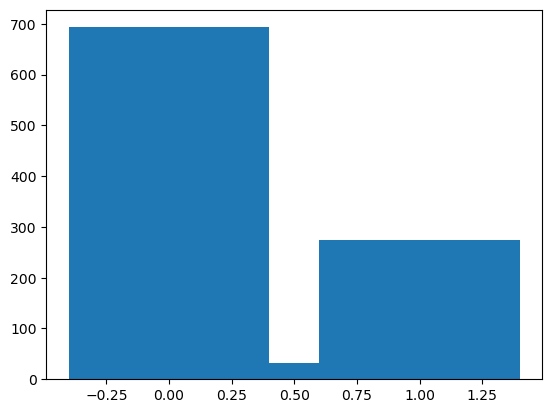

In [400]:
import matplotlib.pyplot as plt 
plt.bar(winner, numbers)
plt.show()